# Clase 4. Preparación de datos. Sección 4. Codificación de variables categóricas

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](https://docs.google.com/presentation/d/1lBF-w7pShz5fd4-LQZvsIUnHJwPomvdqlVNyKYM9Q-M/edit?usp=sharing).

Ejemplos organizados por sección:

Tradicionales:
- One Hot Encoding
- Count/frequency encoding
- Ordinal/label encoding

Relación monotónica:
- Label encoding ordenado.
- Encoding por promedio
- Peso de la evidencia (WoE)

Alternativos:
- Binary encoding
- Feature hashing

In [1]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:1.2.3
Numpy:1.19.2
Matplotlib:3.3.4
SKlearn:0.24.1
Seaborn:0.11.1



Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

diabetes.csv
diabetes_ex.csv
houseprices.csv
housing_ex.csv
titanic.csv


## 1. Preparación de datos

Carga de datasets utilizados para ejemplos.

Precios de propiedades.

In [3]:
df_houseprice = pd.read_csv(DATASET_PATH+"/houseprices.csv")
df_houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Titanic.

In [4]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_titanic["cabin_red"] = df_titanic["Cabin"].map(lambda row: row[0] if isinstance(row,str) else 'N')

In [6]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

## 4. Codificación de variables categóricas

Tradicionales:
- One Hot Encoding
- Count/frequency encoding
- Ordinal/label encoding

Relación monotónica
- Label encoding ordenado.
- Encoding por promedio
- Peso de la evidencia (WoE)

Alternativas:
- Binary encoding
- Feature hashing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic[['Sex', 'Embarked', 'Cabin']], 
    df_titanic['Survived'],  
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((623, 3), (268, 3))

### 4.1 One Hot Encoding

Observación: Pandas tiene la función *get_dummies()*, pero uno de sus inconvenientes es que puede no crear la misma cantidad de variables para train set y test set, por lo tanto, se recomienda usar la implementación de SKlearn (u otra librería que contemple este aspecto).


Codificación, ejemplo para las 3 variables categóricas Sex, Embarked y Cabin.

In [8]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(categories='auto',
                           drop=None, # first/last=k-1,False = k (OHE)
                           sparse=False # No devolver una matriz esparsa
) 

ohe_encoder.fit(X_train.fillna('Missing').values)
ohe_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Missing', 'Q', 'S'], dtype=object),
 array(['A10', 'A14', 'A16', 'A19', 'A23', 'A24', 'A26', 'A32', 'A34',
        'A36', 'B101', 'B102', 'B18', 'B19', 'B20', 'B22', 'B28', 'B3',
        'B35', 'B37', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50',
        'B51 B53 B55', 'B71', 'B73', 'B77', 'B79', 'B80', 'B82 B84', 'B94',
        'B96 B98', 'C101', 'C103', 'C111', 'C118', 'C123', 'C124', 'C125',
        'C128', 'C2', 'C22 C26', 'C23 C25 C27', 'C30', 'C32', 'C46', 'C47',
        'C49', 'C50', 'C54', 'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78',
        'C83', 'C85', 'C87', 'C90', 'C91', 'C92', 'C93', 'C99', 'D', 'D17',
        'D20', 'D26', 'D30', 'D33', 'D35', 'D36', 'D37', 'D45', 'D46',
        'D49', 'D56', 'D6', 'D9', 'E10', 'E101', 'E12', 'E121', 'E17',
        'E24', 'E31', 'E33', 'E40', 'E44', 'E46', 'E50', 'E58', 'E67',
        'E8', 'F E69', 'F G63', 'F G73', 'F2', 'F33', 'F38', 'F4', 'G6',
        'Missing', 'T'], dtype=object)]

En total se crearon 113 variables nuevas.

In [9]:
np.sum([len(x) for x in ohe_encoder.categories_])

113

In [10]:
cat_names = np.concatenate(ohe_encoder.categories_).ravel()
cat_names

array(['female', 'male', 'C', 'Missing', 'Q', 'S', 'A10', 'A14', 'A16',
       'A19', 'A23', 'A24', 'A26', 'A32', 'A34', 'A36', 'B101', 'B102',
       'B18', 'B19', 'B20', 'B22', 'B28', 'B3', 'B35', 'B37', 'B4', 'B41',
       'B42', 'B49', 'B5', 'B50', 'B51 B53 B55', 'B71', 'B73', 'B77',
       'B79', 'B80', 'B82 B84', 'B94', 'B96 B98', 'C101', 'C103', 'C111',
       'C118', 'C123', 'C124', 'C125', 'C128', 'C2', 'C22 C26',
       'C23 C25 C27', 'C30', 'C32', 'C46', 'C47', 'C49', 'C50', 'C54',
       'C62 C64', 'C65', 'C68', 'C7', 'C70', 'C78', 'C83', 'C85', 'C87',
       'C90', 'C91', 'C92', 'C93', 'C99', 'D', 'D17', 'D20', 'D26', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D49', 'D56', 'D6', 'D9',
       'E10', 'E101', 'E12', 'E121', 'E17', 'E24', 'E31', 'E33', 'E40',
       'E44', 'E46', 'E50', 'E58', 'E67', 'E8', 'F E69', 'F G63', 'F G73',
       'F2', 'F33', 'F38', 'F4', 'G6', 'Missing', 'T'], dtype=object)

In [11]:
X_train_encoded = ohe_encoder.transform(X_train.fillna('Missing').values)
X_train_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [12]:
X_train_encoded.shape

(623, 113)

In [13]:
df_train = pd.DataFrame(X_train_encoded,columns=cat_names).astype(int).head(5)
df_train

,female,male,C,Missing,Q,S,A10,A14,A16,A19,...,F E69,F G63,F G73,F2,F33,F38,F4,G6,Missing,T
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


¿Qué pasa si aparecen categorías desconocidas en el test set?

De la documentación de SKLearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
~~~
handle_unknown{‘error’, ‘ignore’}, default=’error’
Whether to raise an error or ignore if an unknown categorical feature is present during transform (default is to raise). When this parameter is set to ‘ignore’ and an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.
~~~

In [14]:
try:
    X_test_encoded = ohe_encoder.transform(X_test.fillna('Missing').values)
except ValueError as error:
    print("Error: ", error)

Error:  Found unknown categories ['D50', 'C52', 'E49', 'E36', 'E77', 'D47', 'B86', 'A7', 'B38', 'D7', 'E34', 'D15', 'C82', 'E25', 'B78', 'C104', 'C126', 'B69', 'C95', 'D48', 'A5', 'C110', 'D19', 'D10 D12', 'A6', 'E68', 'B30', 'C106', 'E38', 'C86', 'C45', 'A31', 'D28', 'C148', 'D11', 'B39', 'A20', 'D21', 'B57 B59 B63 B66', 'B58 B60', 'E63'] in column 2 during transform


Una práctica común es asignar todas las categorías no vistas a una categoría especial, por ejemplo "Other".

#### 4.1.1 One Hot Encoding de top k-categorías

Variante de OHE que sólo codifica las k categorías con mayor presencia.

In [15]:
feature_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']
total_ohe_dims = 0
for col in df_houseprice[feature_cols].columns:
    print(col, ': ', len(df_houseprice[col].unique()), ' etiquetas')
    total_ohe_dims+= len(df_houseprice[col].unique())
print("Total de etiquetas:",total_ohe_dims)

Neighborhood :  25  etiquetas
Exterior1st :  15  etiquetas
Exterior2nd :  16  etiquetas
Total de etiquetas: 56


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprice[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  
    df_houseprice['SalePrice'], 
    test_size=0.3,  
    random_state=42) 
X_train.shape, X_test.shape

((1022, 3), (438, 3))

Importante: implementación sólo a modo de ejemplo, no se está manejando el error ilustrado en OHE de la diferencia entre las variables codificadas para train y test.

In [17]:
def calculate_top_categories(df, variable, k=5):
    """Obtener las k categorías más frecuentes para una variable
    """
    return [ x for x in df[variable].value_counts().sort_values(
             ascending=False).head(k).index ]

def one_hot_encode(train, test, variable, top_x_labels):
    """Por cada categoría, crear una nueva variable <nombre_variable>_<etiqueta> 
       con el valor correspondiente. Se hace para train y test set
       Nota: el resto por defecto quedan en cero.
    """
    for label in top_x_labels:
        train[variable + '_' + label] = np.where(train[variable] == label, 1, 0)        
        test[variable + '_' + label] = np.where(test[variable] == label,1, 0)

In [18]:
for variable in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:    
    # Obtener las top-k categorías de la variable
    top_categories = calculate_top_categories(X_train, variable, k=5)    
    
    # Codificar para esa variable sólo las k categorías
    one_hot_encode(X_train, X_test, variable, top_categories)
X_train.head()    

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Somerst,Exterior1st_VinylSd,Exterior1st_HdBoard,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood
135,NWAmes,Plywood,Plywood,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1452,Edwards,VinylSd,VinylSd,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
762,Somerst,VinylSd,VinylSd,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
932,Somerst,VinylSd,ImStucc,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
435,CollgCr,VinylSd,VinylSd,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [19]:
X_test.head()  

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Somerst,Exterior1st_VinylSd,Exterior1st_HdBoard,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood
892,Sawyer,HdBoard,HdBoard,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1105,NoRidge,HdBoard,HdBoard,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
413,OldTown,WdShing,Wd Shng,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
522,BrkSide,CemntBd,CmentBd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1036,Timber,VinylSd,VinylSd,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


### 4.2 Count/frequency encoding

Consiste en sustituir cada categoría por la cantidad de veces o el porcentaje en que aparece.

In [20]:
count_map = X_train['Neighborhood'].value_counts().to_dict()
count_map

{'NAmes': 155,
 'CollgCr': 109,
 'OldTown': 82,
 'Edwards': 79,
 'Somerst': 57,
 'NWAmes': 54,
 'Gilbert': 52,
 'NridgHt': 50,
 'Sawyer': 48,
 'BrkSide': 41,
 'SawyerW': 38,
 'Crawfor': 38,
 'Mitchel': 34,
 'NoRidge': 28,
 'Timber': 27,
 'IDOTRR': 24,
 'StoneBr': 20,
 'ClearCr': 19,
 'SWISU': 16,
 'Blmngtn': 14,
 'BrDale': 12,
 'MeadowV': 10,
 'Veenker': 8,
 'NPkVill': 6,
 'Blueste': 1}

In [21]:
X_train['Neighborhood'] = X_train['Neighborhood'].map(count_map)
X_test['Neighborhood'] = X_test['Neighborhood'].map(count_map)

In [22]:
X_train.head(5)

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Somerst,Exterior1st_VinylSd,Exterior1st_HdBoard,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood
135,54,Plywood,Plywood,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1452,79,VinylSd,VinylSd,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
762,57,VinylSd,VinylSd,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
932,57,VinylSd,ImStucc,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
435,109,VinylSd,VinylSd,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [23]:
X_test.head(5)

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Somerst,Exterior1st_VinylSd,Exterior1st_HdBoard,Exterior1st_Wd Sdng,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood
892,48,HdBoard,HdBoard,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1105,28,HdBoard,HdBoard,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
413,82,WdShing,Wd Shng,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
522,41,CemntBd,CmentBd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1036,27,VinylSd,VinylSd,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


### 4.3 Ordinal/label encoding

In [24]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

Ejemplo: Dado un dataset con dos variables de entrada, se hallan valores únicos para cada valor.

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [25]:
X = [ ['Male', 1], 
      ['Female', 3], 
      ['Female', 2]]

ord_encoder = OrdinalEncoder()
ord_encoder.fit(X)
ord_encoder.transform([['Female', 3], ['Male', 1]])

array([[0., 2.],
       [1., 0.]])

In [26]:
ord_encoder.inverse_transform([[0., 2.],[1., 0.]])

array([['Female', 3],
       ['Male', 1]], dtype=object)

Ejemplo: Codificar una variable objetivo en 0..(n-1) valores.
Fuente: 

In [27]:
le = LabelEncoder()
le.fit([1, 2, 2, 6])
le.classes_

array([1, 2, 6])

In [28]:
le.transform([1, 1, 2, 6])

array([0, 0, 1, 2], dtype=int64)

In [29]:
le.inverse_transform([0, 0, 1, 2])

array([1, 1, 2, 6])

### 4.4 Label encoding ordenado

Variante de label encoding que asigna un orden a la codificación numérica, por ejemplo usando el valor promedio de la variable objetivo.

In [30]:
df_houseprice.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
# Importante, esta vez SI incluímos la variable objetivo en train_set!
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprice[['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']],  
    df_houseprice['SalePrice'],
    test_size=0.3,
    random_state=42) 
X_train.shape, X_test.shape

((1022, 4), (438, 4))

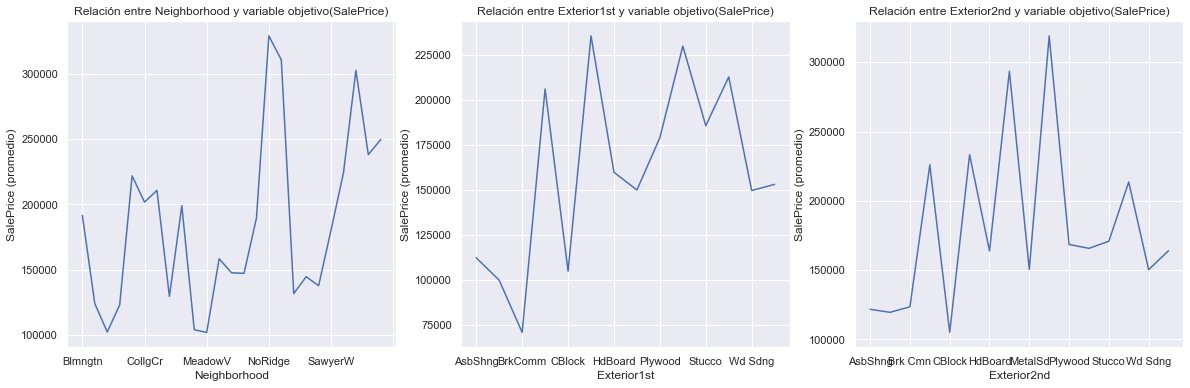

In [32]:
feature_cols =  ['Neighborhood', 'Exterior1st', 'Exterior2nd']
fig,axes = plt.subplots(1,3,figsize=(20,6))
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['SalePrice'].mean().plot(ax=axes[i])
    axes[i].set_title('Relación entre {} y variable objetivo(SalePrice)'.format(var))
    axes[i].set_ylabel('SalePrice (promedio)')

Ejemplo de como podemos obtener una lista ordenada por promedio de la variable objetivo de categorías:

In [33]:
X_train.groupby(['Neighborhood'])['SalePrice'].mean().sort_values()

Neighborhood
MeadowV    101890.000000
BrDale     102208.333333
IDOTRR     103945.833333
BrkSide    122921.951220
Blueste    124000.000000
Edwards    129494.556962
OldTown    131635.768293
Sawyer     137670.833333
SWISU      144586.500000
NPkVill    147125.000000
NAmes      147574.741935
Mitchel    158292.235294
SawyerW    180234.131579
NWAmes     189435.277778
Blmngtn    191501.857143
Gilbert    198925.615385
CollgCr    201698.449541
Crawfor    210745.710526
ClearCr    221842.105263
Somerst    224095.824561
Timber     238072.703704
Veenker    249687.500000
StoneBr    302605.700000
NridgHt    310738.780000
NoRidge    329039.571429
Name: SalePrice, dtype: float64

In [34]:
def find_category_mappings(df, variable, target):
    # Notar que se ordena por promedio, pero se utiliza el índice (0..n-1)
    ordered_labels = X_train.groupby([variable])[target].mean().sort_values().index
    return {k: i for i, k in enumerate(ordered_labels, 0)}

def integer_encode(train, test, variable, ordinal_mapping):
    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [35]:
for variable in ['Neighborhood','Exterior1st', 'Exterior2nd']:
    mappings = find_category_mappings(X_train, variable, 'SalePrice')
    integer_encode(X_train, X_test, variable, mappings)

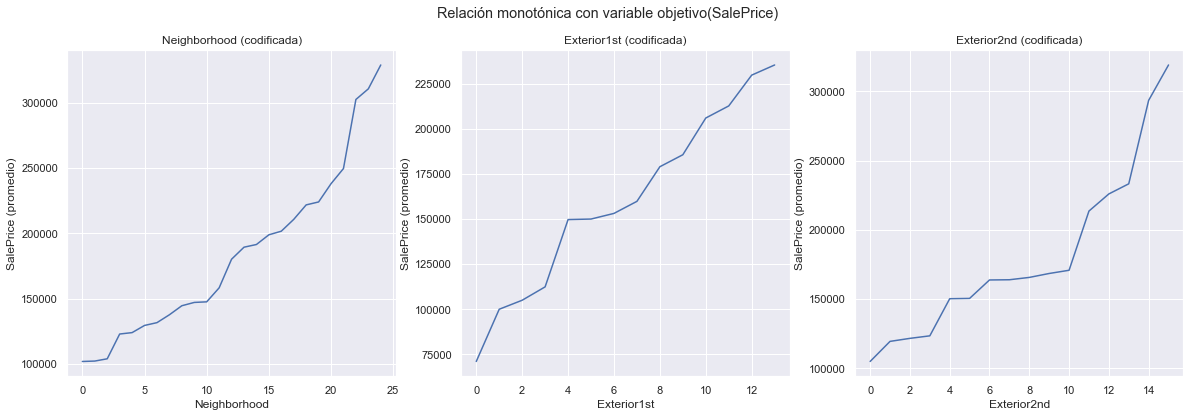

In [36]:
feature_cols =  ['Neighborhood', 'Exterior1st', 'Exterior2nd']
fig,axes = plt.subplots(1,3,figsize=(20,6))
fig.suptitle('Relación monotónica con variable objetivo(SalePrice)')
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['SalePrice'].mean().plot(ax=axes[i])
    axes[i].set_title('{} (codificada)'.format(var))
    axes[i].set_ylabel('SalePrice (promedio)')

Observación: se obtiene una codificación con una relación monotónica entre la variable independiente y la variable objetivo.

### 4.5 Encoding por promedio

Similar al caso anterior, pero esta vez codificando con el promedio en lugar del índice.

In [37]:
df_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_red
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,N
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,N


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic[['cabin_red', 'Sex', 'Embarked', 'Survived']], 
    df_titanic['Survived'], 
    test_size=0.3, 
    random_state=0)
X_train.shape, X_test.shape

((623, 4), (268, 4))

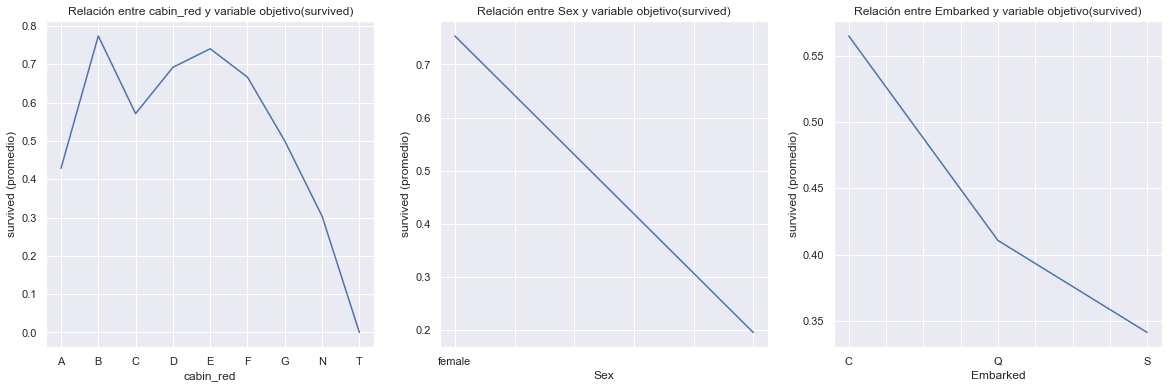

In [39]:
feature_cols = ['cabin_red', 'Sex', 'Embarked']
fig,axes = plt.subplots(1,3,figsize=(20,6))
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['Survived'].mean().plot(ax=axes[i])
    axes[i].set_title('Relación entre {} y variable objetivo(survived)'.format(var))
    axes[i].set_ylabel('survived (promedio)')

In [40]:
X_train.groupby(['cabin_red'])['Survived'].mean()

cabin_red
A    0.428571
B    0.774194
C    0.571429
D    0.692308
E    0.740741
F    0.666667
G    0.500000
N    0.303609
T    0.000000
Name: Survived, dtype: float64

In [41]:
def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()

def integer_encode(train, test, variable, ordinal_mapping):
    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [42]:
for variable in ['cabin_red','Sex', 'Embarked']:
    mappings = find_category_mappings(X_train, variable, 'Survived')
    integer_encode(X_train, X_test, variable, mappings)

In [43]:
X_train.head()

,cabin_red,Sex,Embarked,Survived
857,0.740741,0.196078,0.341357,1
52,0.692308,0.753488,0.564815,1
386,0.303609,0.196078,0.341357,0
124,0.692308,0.196078,0.341357,0
578,0.303609,0.753488,0.564815,0


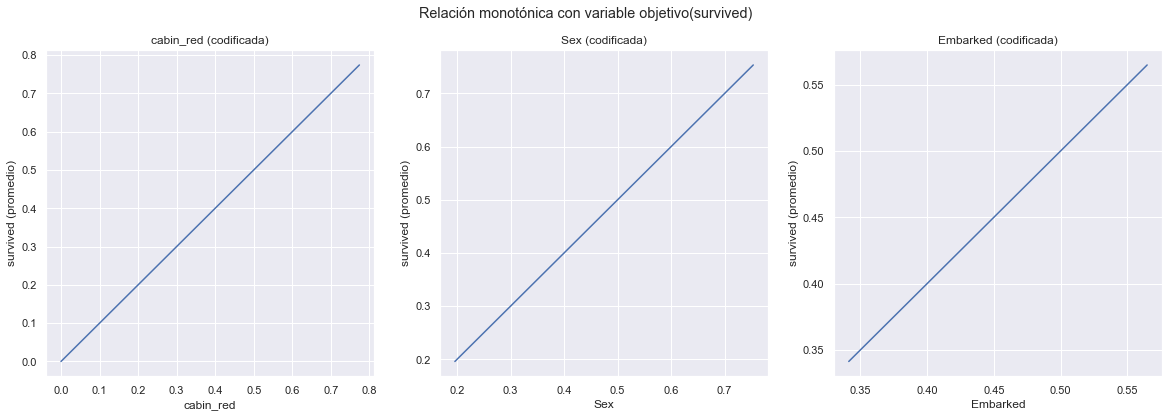

In [44]:
feature_cols = ['cabin_red', 'Sex', 'Embarked']
fig,axes = plt.subplots(1,3,figsize=(20,6))
fig.suptitle('Relación monotónica con variable objetivo(survived)')
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['Survived'].mean().plot(ax=axes[i])
    axes[i].set_title('{} (codificada)'.format(var))
    axes[i].set_ylabel('survived (promedio)')

Observación: se obtiene una codificación con una relación monotónica entre la variable independiente y la variable objetivo.

### 4.6 Weight of evidence

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic[['cabin_red', 'Sex', 'Embarked', 'Survived']], 
    df_titanic['Survived'],  
    test_size=0.3,  
    random_state=42) 
X_train.shape, X_test.shape

((623, 4), (268, 4))

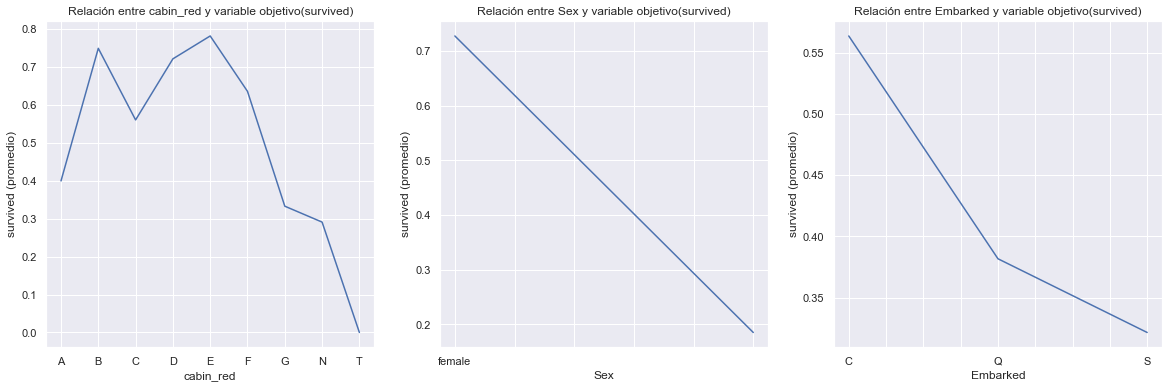

In [46]:
feature_cols = ['cabin_red', 'Sex', 'Embarked']
fig,axes = plt.subplots(1,3,figsize=(20,6))
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['Survived'].mean().plot(ax=axes[i])
    axes[i].set_title('Relación entre {} y variable objetivo(survived)'.format(var))
    axes[i].set_ylabel('survived (promedio)')

In [47]:
prob_df = X_train.groupby(['cabin_red'])['Survived'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df

,Survived
cabin_red,
A,0.400000
B,0.750000
C,0.560976
D,0.722222
E,0.782609
F,0.636364
G,0.333333
N,0.291322
T,0.000000


In [48]:
prob_df['died'] = 1-prob_df['Survived']
prob_df

,Survived,died
cabin_red,,
A,0.400000,0.600000
B,0.750000,0.250000
C,0.560976,0.439024
D,0.722222,0.277778
E,0.782609,0.217391
F,0.636364,0.363636
G,0.333333,0.666667
N,0.291322,0.708678
T,0.000000,1.000000


In [49]:
# Nota: se elimina T porque log(x) indefinido para x=0
prob_df = prob_df.drop(labels=['T'])

In [50]:
prob_df['ratio'] = np.log( prob_df['Survived'] / prob_df['died'] )
prob_df

,Survived,died,ratio
cabin_red,,,
A,0.400000,0.600000,-0.405465
B,0.750000,0.250000,1.098612
C,0.560976,0.439024,0.245122
D,0.722222,0.277778,0.955511
E,0.782609,0.217391,1.280934
F,0.636364,0.363636,0.559616
G,0.333333,0.666667,-0.693147
N,0.291322,0.708678,-0.888971


In [51]:
def find_category_mappings(df, variable, target):
    tmp = pd.DataFrame(df.groupby([variable])[target].mean())    
    tmp['non-target'] = 1 - tmp[target]    
    tmp['ratio'] = np.log( tmp[target] / tmp['non-target'] )
    return tmp['ratio'].to_dict()

def integer_encode(train, test, variable, ordinal_mapping):
    X_train[variable] = X_train[variable].map(ordinal_mapping)    
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [52]:
X_train = X_train.loc[~(X_train.cabin_red=='T')] # Eliminamos T para evitar -inf

In [53]:
for variable in ['cabin_red','Sex', 'Embarked']:    
    mappings = find_category_mappings(X_train, variable, 'Survived')    
    integer_encode(X_train, X_test, variable, mappings)

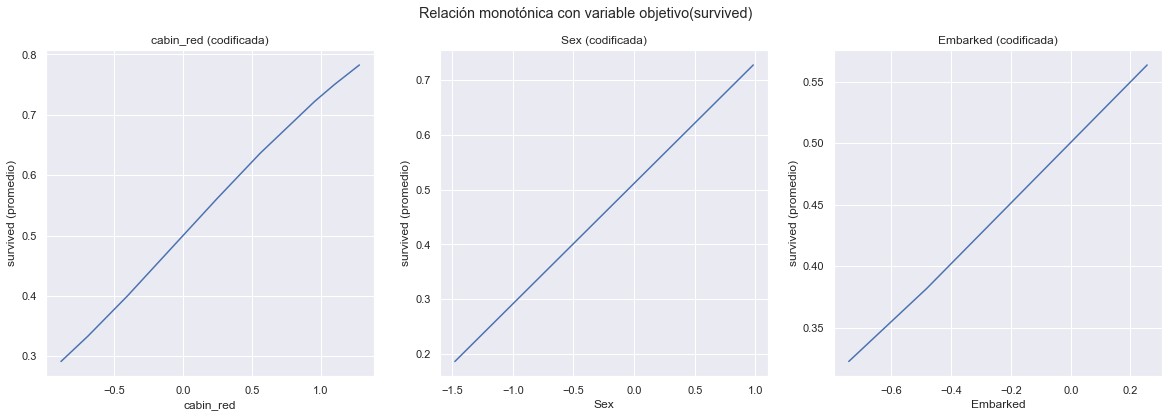

In [54]:
feature_cols = ['cabin_red', 'Sex', 'Embarked']
fig,axes = plt.subplots(1,3,figsize=(20,6))
fig.suptitle('Relación monotónica con variable objetivo(survived)')
for i,var in enumerate(feature_cols):
    X_train.groupby([var])['Survived'].mean().plot(ax=axes[i])
    axes[i].set_title('{} (codificada)'.format(var))
    axes[i].set_ylabel('survived (promedio)')

Observación: se obtiene una codificación con una relación monotónica entre la variable independiente y la variable objetivo.